In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas_profiling as pp
from datetime import datetime
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
import eli5
from eli5.sklearn import PermutationImportance

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None) # display all columns

import warnings
warnings.filterwarnings('ignore')

## Loading dataset

read dataset, define delimiter, dtypes and encoding

In [111]:
df = pd.read_csv('data.csv',
                 delimiter = ';',
                 encoding='utf-8',
                 dtype={"game_event_id":"str",
                        "game_id":"str"})

## Summarize data

In [112]:
# advanced way for df.describe()
pp.ProfileReport(df).to_file('report.html')

## target incidence

In [113]:
# calculate the target incidence (preferred > 5%)
np.sum(df["shot_made_flag"])/len(df)

0.36883682920185235

# create a PIG table

In [114]:
# Function that creates predictor insight graph table
def create_pig_table(df, variable, target):
  
    # Create groups for each variable
    groups = df[[target,variable]].groupby(variable)
    
    # Calculate size and target incidence for each group
    pig_table = groups[target].agg({'Size':np.size, 'Incidence':np.mean}).reset_index()
    
    # Return the predictor insight graph table
    return pig_table

In [115]:
pig_table = create_pig_table(df, "shot_zone_range", "shot_made_flag").sort_values(["Incidence"]).reset_index(drop=True)
pig_table

shot_zone_range    Size  Incidence
0  Back Court Shot    72.0   0.000000
1          24+ ft.  5281.0   0.333333
2        16-24 ft.  6907.0   0.400247
3         8-16 ft.  5580.0   0.441006
4  Less Than 8 ft.  7857.0   0.574137

## create a PIG plot

In [116]:
def plot_pig(pig_table, variable):
    
    # Plot formatting
    plt.ylabel("Size", rotation=0, rotation_mode="anchor", ha="right" )
    
    # Plot the bars with sizes 
    pig_table["Size"].plot(kind="bar", width=0.5, color="lightgray", edgecolor="none") 
    
    # Plot the incidence line on secondary axis
    pig_table["Incidence"].plot(secondary_y=True)
    plt.ylim([0, 1])
    
    # Plot formatting
    plt.xticks(np.arange(len(pig_table)), pig_table[variable])
    plt.xlim([-0.5, len(pig_table) - 0.5])
    plt.ylabel("Incidence", rotation=0, rotation_mode="anchor", ha="left")
    
    plt.show()

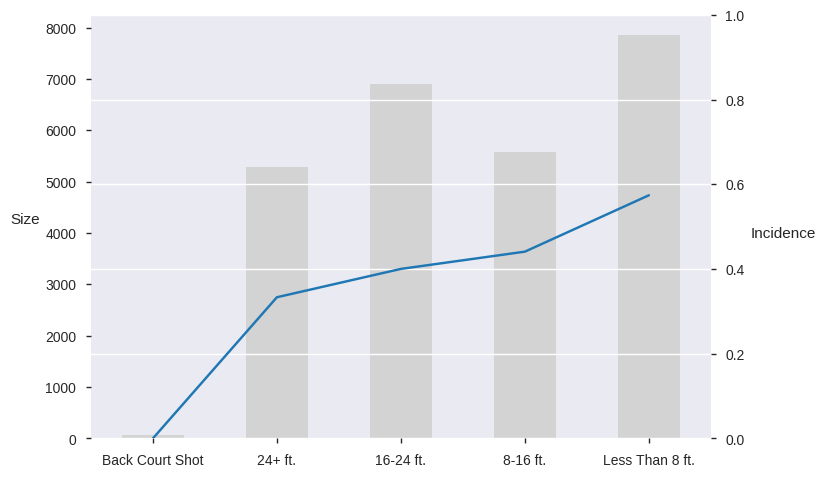

In [117]:
plot_pig(pig_table, "shot_zone_range")

## data cleaning

In [118]:
# set 'game_date' as datetime
df["game_date"] = pd.to_datetime(df["game_date"], format="%d-%m-%Y")

In [119]:
# drop features with only 1 unique value
df = df.drop(['team_id', 'team_name'], axis=1)

In [120]:
# unnecessary columns, since they are correlated to loc_x and loc_y
df = df.drop(['lon', 'lat'], axis=1)

In [121]:
# higly correlated features between eachother can be removed
df = df.drop(['shot_id'], axis=1)

In [122]:
# time remaining, make a new one in seconds = minutes x 60sec + # sec
df['time_remaining_seconds'] = (df['minutes_remaining'] *60) + (df['seconds_remaining'])
df = df.drop(['minutes_remaining', 'seconds_remaining'], axis=1)

In [123]:
# game event ID's are irrelevant to the success of a shot
df = df.drop(['game_id','game_event_id'], axis=1)

## Feature engineering

relevant to the success of a shot

In [124]:
# get info from matchup: home or away?
df['home'] = df['matchup'].apply(lambda x: 1 if 'vs' in x else 0)
df = df.drop('matchup', axis=1)

In [125]:
# make a new feature out of "time_remaining_seconds"
df['last_3_seconds'] = df["time_remaining_seconds"].apply(lambda x: 1 if x < 4 else 0)

In [126]:
# Since the season variable represents the year,
# we only need to extract the month from the date variable.
# The weekday is unlikely to be relevant.

# make a new columns to only keep the months of the date, rest is irrelevant
df['game_month'] = df['game_date'].dt.month
df = df.drop('game_date', axis=1)

## Visualise features vs target

  - X-axis = any feature category
  - y-axis = target

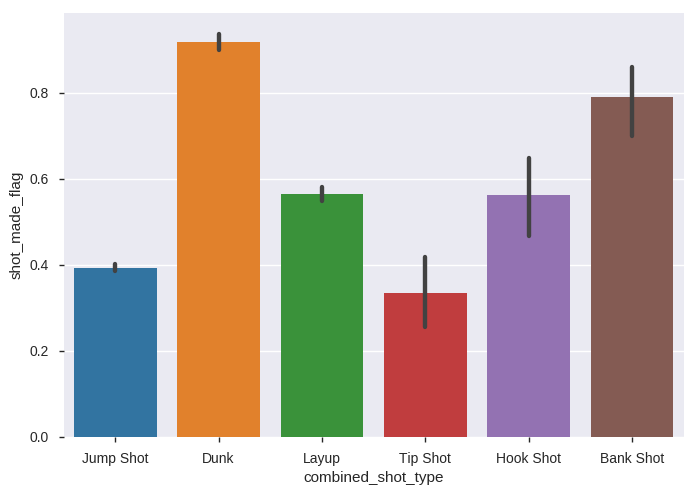

In [127]:
sns.barplot(x='combined_shot_type', y='shot_made_flag', data=df)

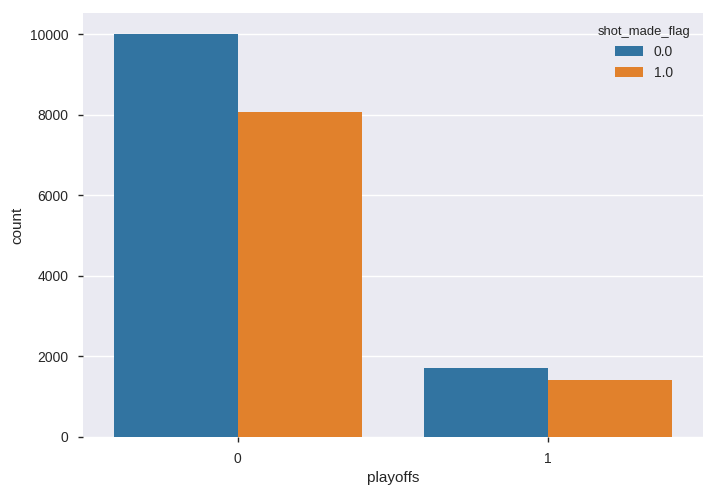

In [128]:
sns.countplot(x='playoffs', hue='shot_made_flag', data=df)
# The proportion of successful shots is similar in the two cases and
# does not seem to depend on the playoff variable.
# Therefore, this variable can be dropped.
df = df.drop('playoffs', axis=1)

## Transform Categorical data for modeling

In [129]:
df.shape

(25697, 17)

In [130]:
for var in df.select_dtypes(include='object').columns.values:
    df = pd.concat([df, pd.get_dummies(df[var], drop_first=True, prefix=var)], 1)
    df = df.drop(var, axis=1)

In [131]:
df.shape

(25697, 135)

## Create a training dataset & submission 'testing' dataset

In [132]:
# Kaggle already selected some rows and made them missing in the target variable:

# submission dataset (features X + target y)
df_test = df[df['shot_made_flag'].isnull()]

# training dataset (features X + target y), to train our models on
df_train = df[df['shot_made_flag'].notnull()]

## create the target dataset

In [133]:
# only target 'shot_made_flag'
y_train = df_train['shot_made_flag']

## create the features dataset

In [134]:
# no need to do a train_test_split(X, y, stratify=y, random_state=0)

# all features except the target
X_train = df_train.drop('shot_made_flag', axis=1)

# X = df.select_dtypes(exclude=["object"]).drop(['shot_made_flag', 'game_date'], axis=1)

## create the features for submission

In [135]:
# all features except the target (for submission)
X_test = df_test.drop('shot_made_flag', axis=1)

# y_test is secret only known by Kaggle

## Summarize the data

In [136]:
# advanced way for .describe method, overwite original report.html
pp.ProfileReport(df_train).to_file('report.html')

## check if we have independent features that correlate/are dependent (not good)

In [171]:
np.abs(X_train.corr()).style.background_gradient()

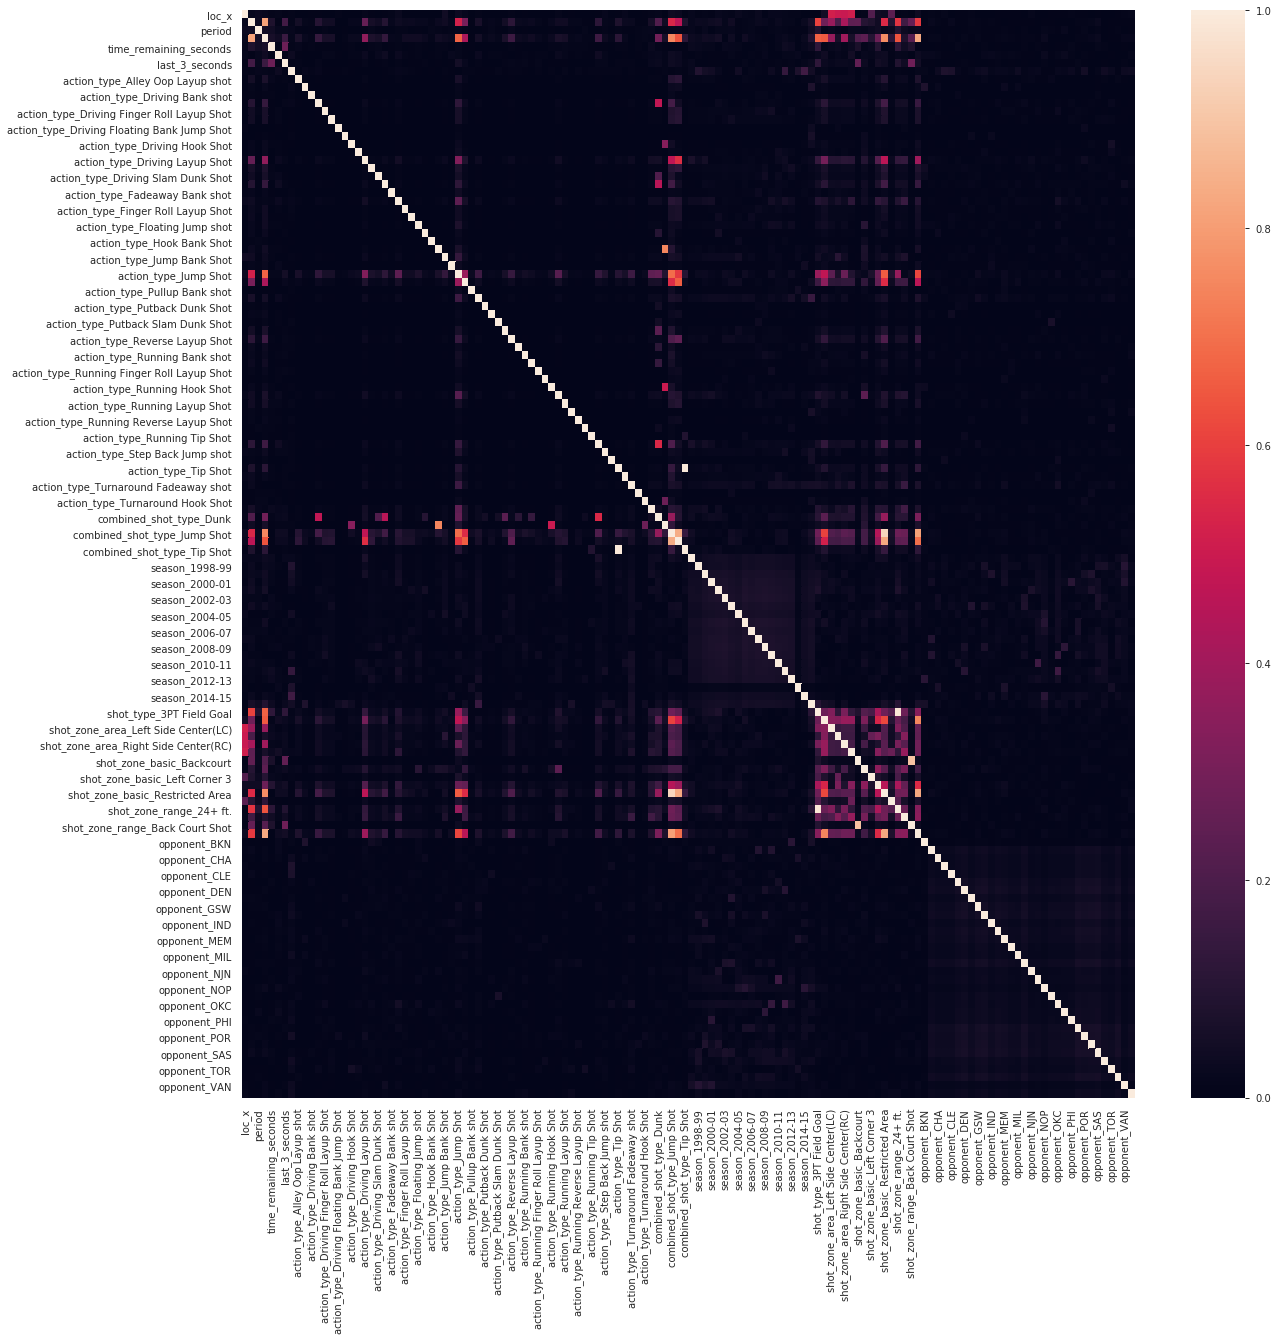

In [190]:
plt.figure(figsize=(20,20))
sns.heatmap(np.abs(X_train.corr()))

## check the feature correlations with the target

Be careful this is not a safe method for feature selection, permutation strategies are more robust

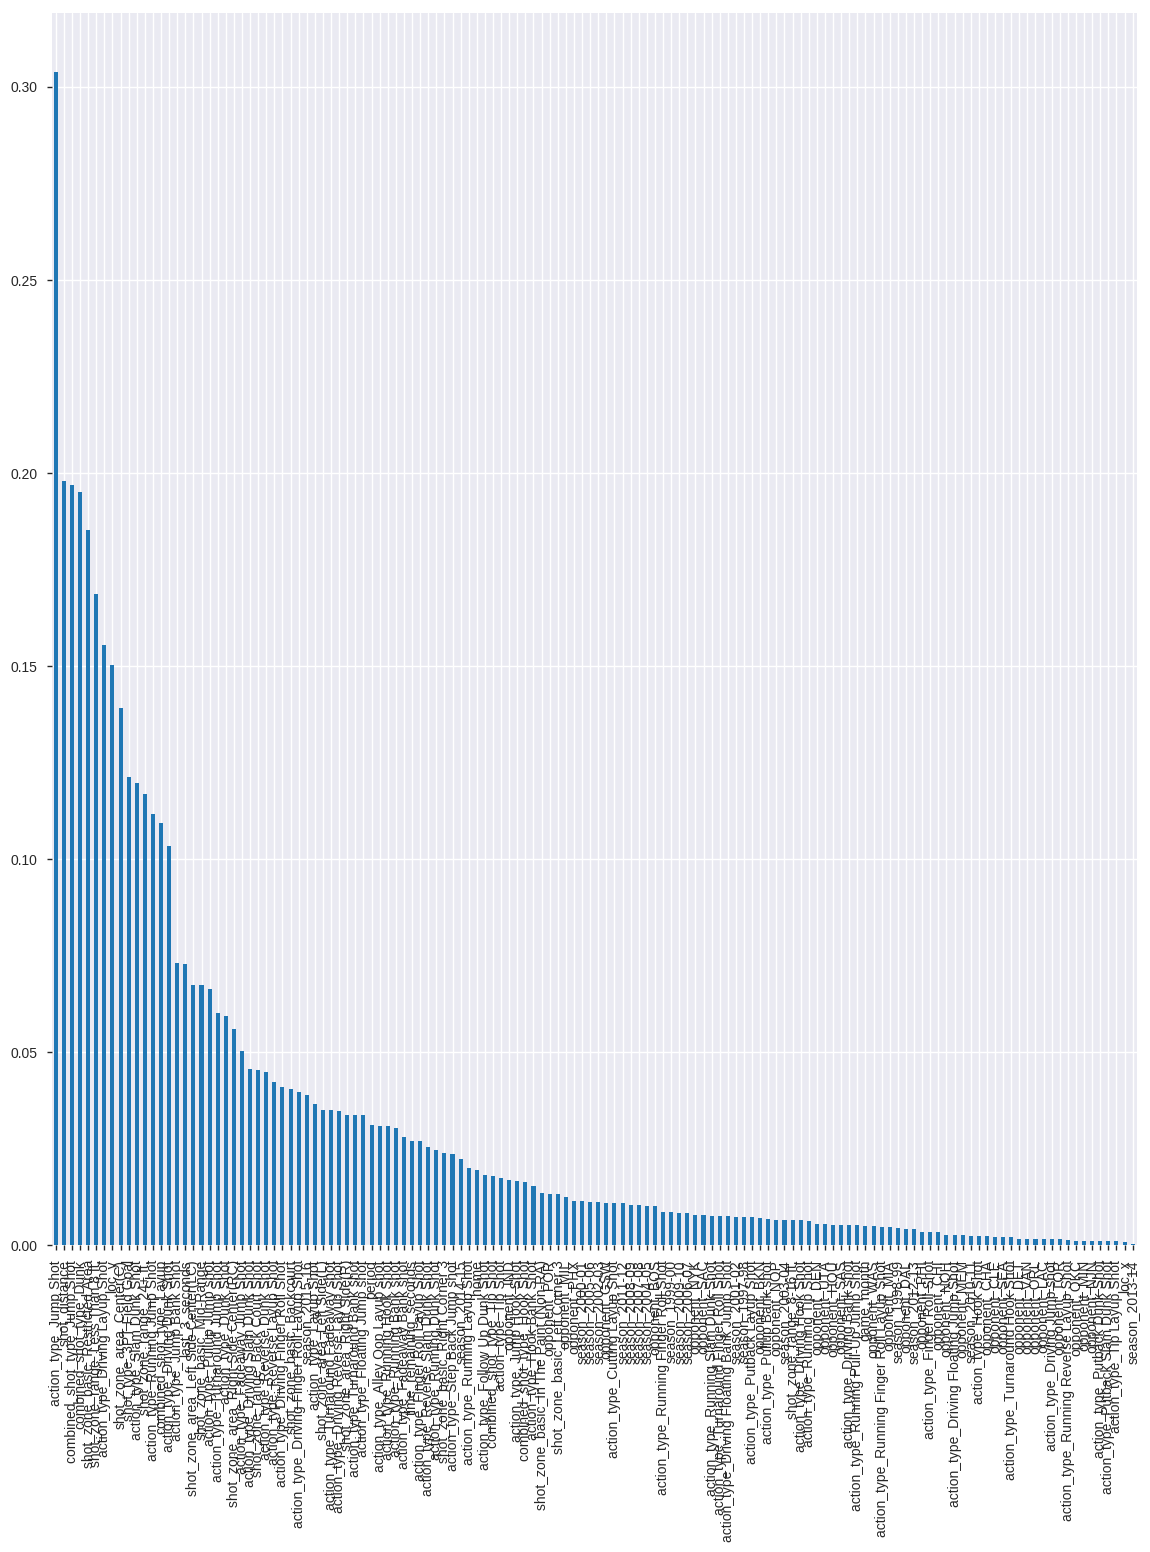

In [185]:
plt.figure(figsize=(20,1))
np.abs(X_train.corrwith(y_train)).sort_values(ascending=False).plot(kind='bar')

## checking variance (skew) of each feature

The models expect normal distributed features,
if values are too high from (preferred: 1) then we can choose to do:

  * np.log()
  * np.sqrt()

In [187]:
np.var(X_train).sort_values(ascending=False)

time_remaining_seconds                         43318.783602
loc_x                                          12173.641157
loc_y                                           7702.586279
shot_distance                                     87.481019
game_month                                        17.224098
period                                             1.328460
home                                               0.249788
shot_zone_area_Center(C)                           0.245995
shot_zone_basic_Mid-Range                          0.241927
action_type_Jump Shot                              0.236928
shot_zone_range_Less Than 8 ft.                    0.211401
combined_shot_type_Jump Shot                       0.178032
shot_zone_basic_Restricted Area                    0.176837
shot_zone_range_8-16 ft.                           0.171327
shot_type_3PT Field Goal                           0.166682
shot_zone_range_24+ ft.                            0.163853
combined_shot_type_Layup                

## choose a model

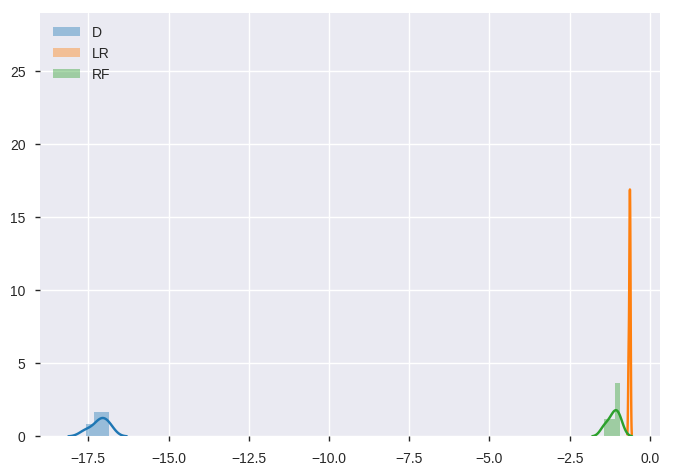

In [28]:
# compare these models: dummy, logistic, Forest, ...
models = []
models.append(('D', DummyClassifier()))
models.append(('LR', LogisticRegression()))
models.append(('RF', RandomForestClassifier()))

results = []

# choose the number of CV splits: 5 (recommended: K=10)
n_splits = 5

cv = StratifiedKFold(n_splits=n_splits, shuffle=False)

# choose the scoring metric: neg_log_loss
for name, model in models:
    score = cross_val_score(model, X_train, y_train, scoring='neg_log_loss', cv=cv, n_jobs=-1)
    results.append((name, score))
    sns.distplot(score, label=name)
    plt.legend()

results = pd.DataFrame(dict(results))

### RandomForest

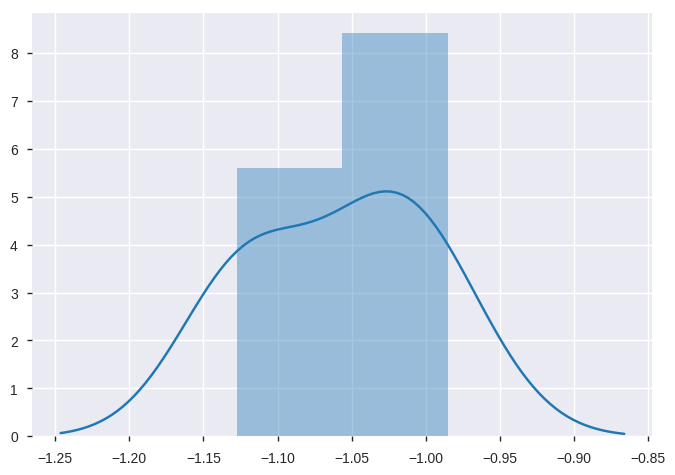

In [29]:
# choose the model, no hyperparameters
model = RandomForestClassifier()
# cross validation parameters
cv = StratifiedKFold(n_splits=n_splits, shuffle=False)
# calculate the scoring of the model for each fold
# n_jobs is set to multi-core processing
score = cross_val_score(model, X_train, y_train, scoring='neg_log_loss', cv=cv, n_jobs=-1)
# plot the distribution
sns.distplot(score)

## Hyperparameter tuning RandomForest

In [30]:
estimator = RandomForestClassifier()

In [31]:
params={'n_estimators':[10,20,30,100,300], 'max_depth':[5,10]}

In [32]:
# choose number of splits: (recommended: 10)
cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

In [33]:
grid = GridSearchCV(estimator, param_grid=params, scoring='neg_log_loss', cv=cv, n_jobs=-1)

In [34]:
%%time
# calculate the best parameters
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [10, 20, 30, 100, 300], 'max_depth': [5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

## hyperparameter Results

In [35]:
grid.__dict__

{'scoring': 'neg_log_loss',
 'estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'n_jobs': -1,
 'fit_params': None,
 'iid': 'warn',
 'refit': True,
 'cv': StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
 'verbose': 0,
 'pre_dispatch': '2*n_jobs',
 'error_score': 'raise-deprecating',
 'return_train_score': 'warn',
 'param_grid': {'n_estimators': [10, 20, 30, 100, 300], 'max_depth': [5, 10]},
 'multimetric_': False,
 'best_index_': 9,
 'best_params_': {'max_depth': 10, 'n_estimators': 300},
 'best_score_': -0.613022628743231,
 'best_estimator_': RandomForestClassifier(bootstrap=True, 

## final predictions

Create the Kaggle submission file

 * col1 = "shot_id"
 * col2 = "shot_made_flag"

In [36]:
# run the optimal model on the X_test
submission = pd.read_csv("sample_submission.csv", delimiter=";")

In [37]:
# create prediction values
# notice: the X_test has had the same feature cleaning, engineering, transformations !
submission['shot_made_flag'] = grid.predict_proba(X_test)[:,1]

In [38]:
# save file: submission.csv
submission.to_csv("submission.csv", index=False)

In [39]:
# comment out bad code, kaggle will testrun the code and calculate the submission file results leaderboard score

## Model Evaluation with the training dataset

we do not have access to the y_test

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [41]:
X = X_train
y = y_train
# choose the split size: 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101, stratify=y)

## Evaluation based on optimal model (classification)

In [42]:
print(classification_report(y_test, grid.best_estimator_.predict(X_test) ))

              precision    recall  f1-score   support

         0.0       0.67      0.86      0.75      3516
         1.0       0.74      0.47      0.58      2844

   micro avg       0.69      0.69      0.69      6360
   macro avg       0.70      0.67      0.66      6360
weighted avg       0.70      0.69      0.67      6360



In [43]:
confusion_matrix(y_test, grid.best_estimator_.predict(X_test))

array([[3032,  484],
       [1498, 1346]])

In [44]:
# calculate the log_loss, remember you need to use predict_proba !
log_loss(y_test, grid.best_estimator_.predict_proba(X_test)[:,1])

0.5935488169413934

In [45]:
# calculate the roc_auc score, remember you need to use predict_proba !
roc_auc_score(y_test, grid.best_estimator_.predict_proba(X_test)[:,1])

0.7636419266395613

In [46]:
import matplotlib.pyplot as plt
import scikitplot as skplt

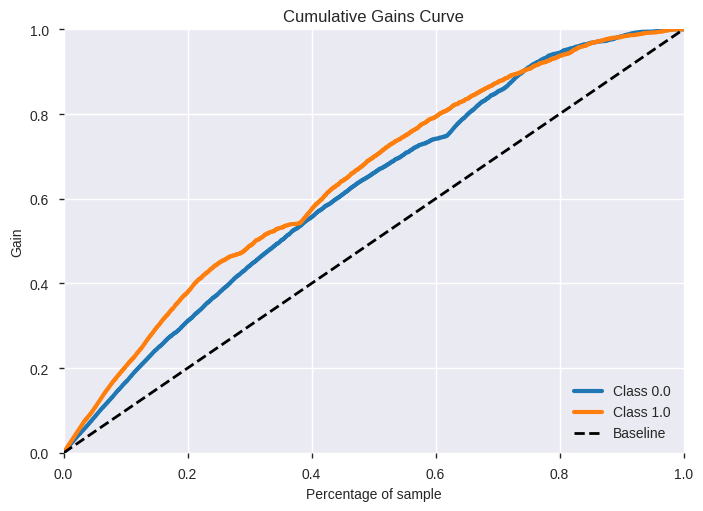

In [47]:
skplt.metrics.plot_cumulative_gain(y_test, grid.best_estimator_.predict_proba(X_test))

In [143]:
from sklearn.preprocessing import StandardScaler

In [144]:
scaler = StandardScaler()

In [147]:
X_train_scaled = scaler.fit_transform(X_train)

In [159]:
# make it back into a dataframe
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Feature selection

## plot cumulative sum variance ratio to show much variables explain 90%

In [160]:
from sklearn.decomposition import PCA

In [161]:
pca = PCA()

In [162]:
pca_var_ratio = pca.fit(X_train_scaled).explained_variance_ratio_

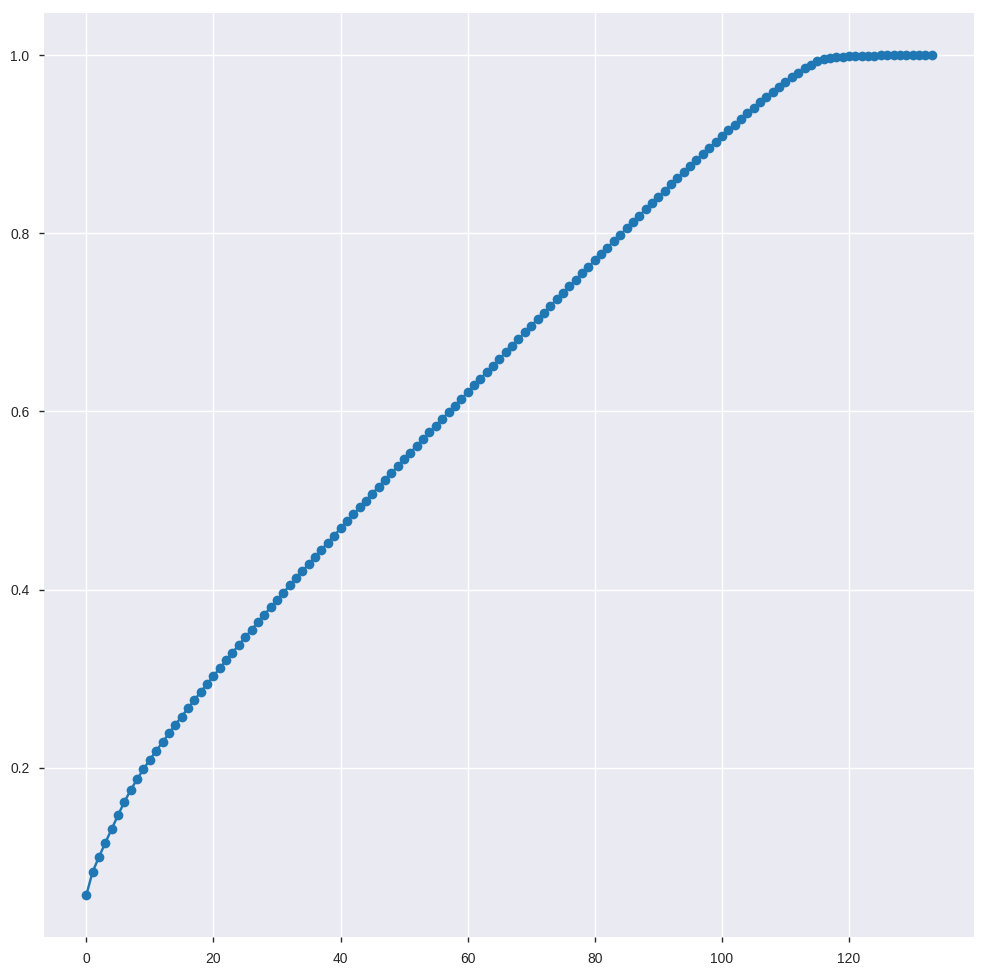

In [163]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.plot(range(len(pca_var_ratio)), np.cumsum(pca_var_ratio), marker='o')

## automated feature selection using PCA up to 90%

In [102]:
pca = PCA(n_components=0.9, svd_solver='full')

In [103]:
X_train_pca = pca.fit_transform(X_train_scaled)

In [104]:
print("Keep {}/{} features".format(X_train_pca.shape[1], X_train.shape[1]))

Keep 99/134 features


## detect BIAS and Feature Importance (Permutation method)

In [172]:
# performance intensive
perm = PermutationImportance(grid.best_estimator_)

In [173]:
%%time
perm.fit(X_train, y_train)

CPU times: user 6min 33s, sys: 706 ms, total: 6min 34s
Wall time: 6min 36s


PermutationImportance(cv='prefit',
           estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
           n_iter=5, random_state=None, refit=True, scoring=None)

In [174]:
# to see the importance values : feature_importances_
perm.__dict__

{'refit': True,
 'estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=10, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'scoring': None,
 'n_iter': 5,
 'random_state': None,
 'cv': 'prefit',
 'rng_': <mtrand.RandomState at 0x7ff00e044750>,
 'scorer_': <function sklearn.metrics.scorer._passthrough_scorer(estimator, *args, **kwargs)>,
 'scores_': array([0.69292824, 0.69292824, 0.69292824, 0.69292824, 0.69292824]),
 'results_': [array([ 2.59470680e-03,  4.38741331e-03,  1.36811813e-03,  3.25517762e-03,
          2.83058923e-03,  1.65117705e-03,  3.30235411e-04,  1.79270652e-03,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  4.71764872e-05,


In [175]:
# green/red : positive/negative importance
# zero's and negatives features can be removed
# BIAS : optional value to watch out for
# this is better than doing a correlation with target

eli5.show_weights(perm, feature_names=X_train_scaled.columns.values, top=None)

#if it fails use below:
#eli5.show_weights(perm, feature_names=X_train.columns.values, top=None)